In [1]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow_io.dicom import decode_dicom_image, decode_dicom_data, tags
import tensorflow_hub as hub
import os
import time
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

In [3]:
!ls data/

stage_1_sample_submission.csv  stage_1_train_images
stage_1_test_images	       stage_1_train_images_sample
stage_1_train.csv


In [4]:
DATA_DIR = 'data/'
IMG_DATA_DIR = os.path.join(DATA_DIR, 'stage_1_train_images/')
MODEL_DIR = 'model/'
BATCH_SIZE = 16
IMG_WIDTH = 512
IMG_HEIGHT = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocess Label

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train.csv'))
df.columns = ['id', 'value']
df['img_id'] = df['id'].apply(lambda x: x.split('_')[1])
df['label'] = df['id'].apply(lambda x: x.split('_')[2])
# Remove duplicate img_id
df = df.drop_duplicates(subset=['img_id', 'label'], keep='first')
# Pivot
df_label = df.pivot(index='img_id', columns='label', values='value').reset_index()

In [6]:
# build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=df_label.img_id.str.encode('utf-8'),
        values=df_label['any'],
    ),
    default_value=tf.constant(-1),
    name='lookup',
)

# Preprocess File Names

In [7]:
fns_all = [ x.numpy().decode('utf-8') for x in tf.data.Dataset.list_files(IMG_DATA_DIR + '*', seed=42) ]
fns_train, fns_test = train_test_split(fns_all, train_size=0.85)
fns_train, fns_val = train_test_split(fns_train, train_size=5/6)

# Process Image

In [8]:
# def get_string(file_path):
#     return file_path.numpy().decode('utf-8')

def get_label_any(file_path):
    return table.lookup(get_img_id(file_path))

def get_img_id(file_path):
    dcm = tf.io.read_file(file_path)
    sop_instance_uid = decode_dicom_data(dcm, tags=tags.SOPInstanceUID)
    return tf.strings.regex_replace(sop_instance_uid, r"ID_(.*)", r"\1")

def get_img_data(file_path):
    dcm = tf.io.read_file(file_path)
    intercept = tf.strings.to_number(decode_dicom_data(dcm, tags=tags.RescaleIntercept))
    slope = tf.strings.to_number(decode_dicom_data(dcm, tags=tags.RescaleSlope))
    img = decode_dicom_image(dcm, color_dim=True, on_error='lossy', dtype=tf.float32)
    dcm_image = img * slope + intercept
    #dcm_image = tf.reshape(dcm_image, (IMG_WIDTH, IMG_HEIGHT, 1))
    dcm_image = dcm_image[0, ...]
    return dcm_image

def process_path(file_path):
    # Load image id
    img_id = get_img_id(file_path)
    # load DICOCM image
    img = get_img_data(file_path)
    # load label
    label = get_label_any(file_path)
    return img, label

def calc_bg(img):
    X, Y = np.meshgrid(np.arange(IMG_WIDTH), np.arange(IMG_HEIGHT))
    R_sq = (X - IMG_WIDTH/2)**2 + (Y - IMG_HEIGHT/2)**2
    mask = ((IMG_WIDTH/2 * 0.0)**2 < R_sq) & (R_sq < (IMG_WIDTH/2 * 0.9)**2)
    mask = mask[..., np.newaxis]
    # Background level
    vals, _ = tf.math.top_k(
        tf.reshape(img * mask, [-1]),
        k=mask.flatten().sum() * 0.8,
        sorted=False,
    )
    # Soft tissue level
    level_bg = tf.reduce_min(vals)
    return level_bg

def calc_soft(img):
    bins = tf.range(500, 5100, 100, dtype=tf.float32)
    hist = tf.histogram_fixed_width(
        tf.reshape(img, [-1]),
        [bins[0], bins[-1]],
        nbins=tf.size(bins)-1,
    )
    hist = hist[1:]
    bins = bins[1:]
    level_soft = bins[tf.math.argmax(hist)]
    return level_soft
    
def process_img(img, flag_aug=False, size=None):
    # Specify size
    img = tf.image.resize_with_crop_or_pad(
        img,
        IMG_HEIGHT,
        IMG_WIDTH,
    )
    # Specify dtype
    img = tf.cast(img, tf.float32)
    # Normalization (shift)
    level_bg = calc_bg(img)
    img = img - level_bg
    img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=9999999)
    # Normalization (scale)
    level_soft = calc_soft(img)
    img = img / (1E-8 + level_soft) * 0.5
    # Color expansion
    img = tf.tile(img, (1, 1, 3))
    # Resize
    if size is not None:
        img = tf.image.resize(
            img,
            size,
            method='nearest',
        )
    # Augmentation
    if flag_aug:
        ## Flip
        img = tf.image.random_flip_left_right(img)
    return img
    

def prepare_for_training(ds, shuffle=True, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ## Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def input_fn():
    #list_ds = tf.data.Dataset.list_files(IMG_DATA_DIR + '*', seed=42)
    # Prepare dataset
    data = [
        tf.data.Dataset.from_tensor_slices(fns_train),
        tf.data.Dataset.from_tensor_slices(fns_val),
        tf.data.Dataset.from_tensor_slices(fns_test),
    ]
    
    # Pre-process
    for i in range(len(data)):
        x = data[i]
        x = x.map(process_path, num_parallel_calls=AUTOTUNE)
        x = x.map(lambda x,y: (process_img(x, flag_aug=True, size=(224, 224)), y), num_parallel_calls=AUTOTUNE)
        
        # Prepare for training (shuffle, batching, etc.)
        if i == 0:
            # Train
            x = prepare_for_training(x, cache=True, shuffle_buffer_size=100)
        else:
            # Val/Test
            x = prepare_for_training(x, shuffle=False, cache=True)
        
        data[i] = x
    
    return data

def show_batch(image_batch, label_batch, batch_size=BATCH_SIZE, flag_hist=False):
    image_batch = np.squeeze(image_batch)
    plt.figure(figsize=(16,16))
    for n in range(batch_size):
        if flag_hist:
            ax = plt.subplot(batch_size,2,n*2+1)
        else:
            ax = plt.subplot(np.ceil(batch_size**0.5),np.ceil(batch_size**0.5),n+1)
        img = image_batch[n]
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Label {}'.format(label_batch[n]))
        plt.axis('off')
        
        if flag_hist:
            ax = plt.subplot(batch_size,2,n*2+2)
            sns.distplot(img.flatten())

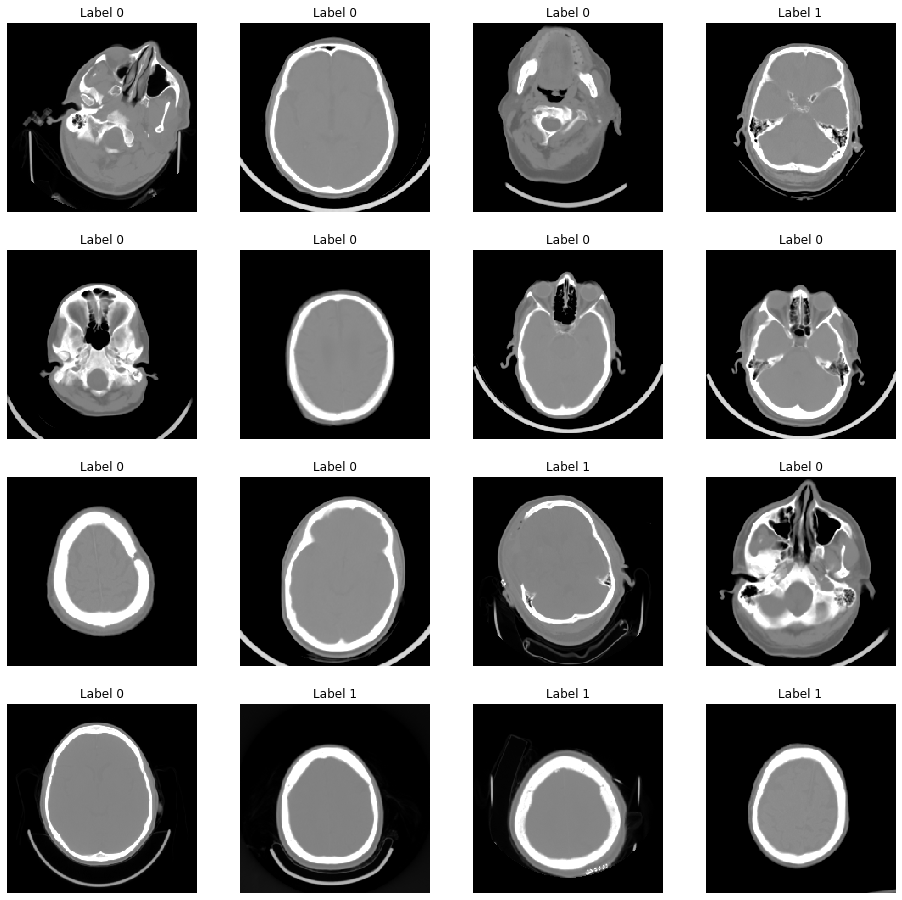

In [17]:
for image_batch, label_batch in input_fn()[0].take(1):
    show_batch(image_batch.numpy(), label_batch.numpy())

# Prepare Training

## Create model

Use pretrained feature extractor "Feature vectors of images with MobileNet V2 (depth multiplier 1.40) trained on ImageNet (ILSVRC-2012-CLS)."

In [9]:
feature_extractor_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4'

In [10]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_url,
    input_shape=(224, 224, 3),
)
# feature_extractor_layer.trainable = False

In [11]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 2)                 3586      
Total params: 4,367,298
Trainable params: 3,586
Non-trainable params: 4,363,712
_________________________________________________________________


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

## Split data

In [13]:
train_data, val_data, test_data = input_fn()

In [14]:
history = model.fit_generator(
    train_data, 
    epochs=10,
    validation_data=val_data,
)

Epoch 1/10
 2786/29850 [=>............................] - ETA: 2:02:22 - loss: 0.2090 - acc: 0.4919

KeyboardInterrupt: 

# Convert Keras model to TF Estimator (Currently buggy)

In [ ]:
estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, 
    model_dir=MODEL_DIR,
)

In [ ]:
estimator.train(input_fn=input_fn, steps=1000)